<a href="https://colab.research.google.com/github/Nyamu007/POTHOLE-DETECTION/blob/main/finetune_yolo12_pothole_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Jun 11 10:52:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [3]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 56.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 126.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Download dataset from Roboflow Universe

In [4]:
from google.colab import userdata
ROBOFLOW_API = userdata.get('ROBOFLOW_API')

In [5]:


!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key=ROBOFLOW_API)
project = rf.workspace("potholes-r7qcn").project("pothole-jujbl")
version = project.version(1)
dataset = version.download("yolov12")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pothole-1 in yolov12:: 100%|██████████| 5554/5554 [00:01<00:00, 3875.99it/s]


In [6]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [7]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [8]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['Pothole']

roboflow:
  workspace: potholes-r7qcn
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [9]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
New https://pypi.org/project/ultralytics/8.3.153 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/Pothole-1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=Tr

100%|██████████| 755k/755k [00:00<00:00, 24.6MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 117MB/s]


AMP: checks passed ✅


train: Scanning /content/Pothole-1/train/labels... 1939 images, 10 backgrounds, 0 corrupt: 100%|██████████| 1939/1939 [00:00<00:00, 2411.89it/s]


train: New cache created: /content/Pothole-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/Pothole-1/valid/labels... 555 images, 4 backgrounds, 0 corrupt: 100%|██████████| 555/555 [00:00<00:00, 1354.40it/s]


val: New cache created: /content/Pothole-1/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       6.8G      3.497      3.814      3.977          8        640: 100%|██████████| 122/122 [01:10<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:08<00:00,  2.15it/s]

                   all        555       1449    0.00265      0.305    0.00265   0.000885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.72G          3      3.411      3.268          9        640: 100%|██████████| 122/122 [01:05<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.44it/s]


                   all        555       1449    0.00364      0.297    0.00442    0.00118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.93G      2.788      3.216      2.982          8        640: 100%|██████████| 122/122 [01:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.62it/s]

                   all        555       1449    0.00629      0.128    0.00514    0.00154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.71G      2.638      3.097      2.821         11        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.31it/s]


                   all        555       1449     0.0363     0.0428     0.0113    0.00322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.74G      2.495      2.931       2.67          6        640: 100%|██████████| 122/122 [01:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


                   all        555       1449     0.0384     0.0476     0.0138    0.00413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.69G      2.371      2.856      2.594         22        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.38it/s]


                   all        555       1449      0.119      0.141     0.0649     0.0212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.74G      2.285      2.723      2.503          7        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.41it/s]


                   all        555       1449      0.245      0.188      0.136     0.0505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.87G      2.217      2.674      2.424         12        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.45it/s]


                   all        555       1449       0.25      0.223      0.162     0.0585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.94G      2.137      2.573      2.351         11        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.61it/s]


                   all        555       1449      0.261      0.219      0.162     0.0602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.85G      2.114       2.53       2.29         12        640: 100%|██████████| 122/122 [01:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.61it/s]


                   all        555       1449       0.34      0.277      0.244     0.0946

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.72G      2.052      2.426      2.233         13        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.41it/s]


                   all        555       1449      0.262      0.322      0.216     0.0871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.69G      2.034      2.409      2.189         12        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.45it/s]


                   all        555       1449      0.242       0.22      0.153     0.0573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.75G      1.998      2.342      2.151          8        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.48it/s]


                   all        555       1449      0.351      0.321      0.272      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.69G      1.989      2.316      2.129         11        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.63it/s]


                   all        555       1449      0.407      0.349      0.327      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       6.9G      1.984      2.311       2.12          8        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.52it/s]


                   all        555       1449      0.318      0.245      0.188     0.0747

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.88G      1.953      2.273      2.073         15        640: 100%|██████████| 122/122 [01:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.48it/s]


                   all        555       1449      0.428      0.359      0.341      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.72G      1.926      2.212      2.045         30        640: 100%|██████████| 122/122 [01:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.44it/s]


                   all        555       1449       0.37      0.268      0.244     0.0992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.68G      1.936      2.257      2.077         16        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.41it/s]


                   all        555       1449      0.423      0.296      0.277      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.74G      1.879      2.151      2.005         14        640: 100%|██████████| 122/122 [01:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.55it/s]

                   all        555       1449      0.447      0.412      0.371       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.69G      1.873       2.14      1.998         17        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.62it/s]


                   all        555       1449      0.493      0.364      0.393      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.91G      1.882      2.107      1.999         14        640: 100%|██████████| 122/122 [01:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.53it/s]


                   all        555       1449      0.479      0.375      0.364      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.85G      1.851      2.114      1.986          6        640: 100%|██████████| 122/122 [01:04<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.45it/s]


                   all        555       1449       0.46      0.381       0.39      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.92G      1.825      2.079      1.949         11        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.44it/s]


                   all        555       1449      0.515       0.38      0.404      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.71G      1.836      2.079      1.952         23        640: 100%|██████████| 122/122 [01:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.58it/s]

                   all        555       1449      0.478      0.404      0.389       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.89G      1.841      2.061       1.96         27        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.63it/s]


                   all        555       1449       0.49      0.421      0.436        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.88G      1.801      2.011      1.922         12        640: 100%|██████████| 122/122 [01:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.53it/s]


                   all        555       1449      0.556       0.42      0.457      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.89G      1.802      2.031      1.929         18        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.40it/s]


                   all        555       1449      0.494       0.37      0.394      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.71G      1.786      1.995      1.901          7        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.43it/s]

                   all        555       1449      0.492      0.431      0.434      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.91G      1.768      1.944      1.881          9        640: 100%|██████████| 122/122 [01:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.61it/s]


                   all        555       1449      0.534      0.423      0.448      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.71G      1.771      1.984      1.894         16        640: 100%|██████████| 122/122 [01:04<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


                   all        555       1449      0.541      0.441      0.477       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.88G      1.762      1.933      1.885          6        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


                   all        555       1449      0.496      0.428      0.444      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.88G      1.747      1.906      1.852         10        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.44it/s]


                   all        555       1449      0.509      0.445      0.472      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.95G       1.74      1.846      1.848         11        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.52it/s]


                   all        555       1449      0.525      0.458       0.47      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.74G      1.738      1.886      1.856         12        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


                   all        555       1449      0.508      0.449      0.475      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       6.9G      1.725      1.867      1.854          7        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.63it/s]


                   all        555       1449      0.576       0.46      0.511      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.88G      1.715      1.847      1.825         10        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.44it/s]


                   all        555       1449      0.573      0.476       0.51      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.89G      1.702       1.82      1.815          7        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.48it/s]


                   all        555       1449      0.589        0.5      0.534      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.87G      1.714      1.795      1.812         17        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.61it/s]


                   all        555       1449       0.59      0.495      0.538      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.92G      1.706      1.814      1.809         10        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.64it/s]


                   all        555       1449      0.541      0.502      0.517      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.85G      1.698      1.814      1.809         10        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.50it/s]


                   all        555       1449      0.589      0.515      0.543      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.71G      1.703      1.821      1.813          6        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


                   all        555       1449      0.524      0.467      0.494      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.71G      1.692      1.788      1.804         14        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.51it/s]


                   all        555       1449      0.634      0.464      0.531      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.88G      1.664      1.788      1.783          4        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.63it/s]


                   all        555       1449      0.591      0.443      0.505      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.88G      1.677      1.772      1.783         13        640: 100%|██████████| 122/122 [01:04<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


                   all        555       1449      0.597      0.481      0.547      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.89G      1.677      1.776      1.794         14        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.47it/s]


                   all        555       1449      0.573      0.501      0.534      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       6.9G      1.659      1.744      1.776          8        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.45it/s]


                   all        555       1449      0.605      0.473      0.537      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.89G      1.668      1.732      1.767          9        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.56it/s]


                   all        555       1449      0.608      0.531      0.572        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.73G      1.649       1.73      1.765         21        640: 100%|██████████| 122/122 [01:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


                   all        555       1449      0.559      0.523      0.554      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.93G      1.639      1.704      1.757         10        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


                   all        555       1449      0.606      0.512      0.552      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.69G       1.64      1.715      1.755         11        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


                   all        555       1449      0.612      0.522      0.574       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.94G      1.639      1.719      1.771         11        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.48it/s]


                   all        555       1449      0.586      0.513      0.553      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.87G      1.622      1.672      1.743          9        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.55it/s]

                   all        555       1449      0.562      0.517      0.544      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.74G      1.631      1.675      1.739         31        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


                   all        555       1449      0.623      0.542      0.597      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.69G      1.615      1.661      1.741          7        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.52it/s]


                   all        555       1449      0.653      0.504      0.581        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.72G      1.607       1.66      1.727         12        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.47it/s]


                   all        555       1449      0.622      0.522      0.584      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.88G       1.59      1.629      1.718         11        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.52it/s]


                   all        555       1449      0.629       0.54      0.592      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.92G      1.621       1.67      1.744          3        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


                   all        555       1449       0.61      0.536       0.59      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.69G      1.595       1.63      1.721         13        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.64it/s]


                   all        555       1449      0.617      0.542      0.583      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.91G      1.601      1.637      1.721         11        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.47it/s]


                   all        555       1449       0.61       0.55      0.591      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.87G      1.585      1.597      1.692         16        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


                   all        555       1449      0.624      0.561      0.601      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.76G      1.585      1.637      1.709         17        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.60it/s]

                   all        555       1449      0.636      0.533      0.589      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.85G      1.589      1.612      1.715         13        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.68it/s]


                   all        555       1449       0.64      0.548      0.606      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.91G      1.588      1.589      1.699         12        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


                   all        555       1449       0.65      0.521      0.587      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       6.7G      1.573      1.599      1.698         12        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.44it/s]

                   all        555       1449      0.671      0.542       0.61      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.88G      1.556      1.573      1.677         22        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.48it/s]

                   all        555       1449      0.629      0.589      0.624      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.88G       1.56      1.567      1.682         13        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


                   all        555       1449      0.597      0.564      0.598      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.94G      1.555      1.547      1.678          8        640: 100%|██████████| 122/122 [01:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.60it/s]


                   all        555       1449      0.659      0.578      0.628      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.88G      1.543       1.55       1.66         10        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.50it/s]


                   all        555       1449      0.648       0.58      0.631      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.72G      1.552      1.551      1.676         12        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.52it/s]


                   all        555       1449      0.636      0.582      0.616      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.72G      1.547      1.534      1.666         15        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


                   all        555       1449       0.66      0.582      0.636      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.72G      1.536      1.526      1.665         13        640: 100%|██████████| 122/122 [01:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


                   all        555       1449      0.668      0.575      0.632      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.88G      1.526      1.509      1.648          8        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.49it/s]


                   all        555       1449      0.668      0.547      0.626      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.72G      1.536       1.51      1.656          9        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.52it/s]


                   all        555       1449      0.642      0.578      0.647      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.71G      1.531      1.498      1.661          4        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


                   all        555       1449      0.679      0.585      0.647      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.89G      1.519      1.503       1.65         11        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.66it/s]

                   all        555       1449      0.676      0.579      0.642       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       6.7G      1.515      1.492      1.655          7        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


                   all        555       1449      0.677      0.582       0.64      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.92G      1.508      1.477      1.644          9        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


                   all        555       1449      0.659      0.596      0.641      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.72G       1.52      1.492       1.65         18        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.60it/s]


                   all        555       1449      0.678      0.576      0.638      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       6.9G      1.511      1.473      1.635         11        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


                   all        555       1449      0.684      0.586      0.665      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.71G      1.493      1.481      1.629         22        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.48it/s]


                   all        555       1449      0.682      0.586      0.653      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.73G      1.511      1.475      1.638          9        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.47it/s]


                   all        555       1449      0.664      0.604      0.662      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.69G      1.503      1.454      1.638          5        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.51it/s]


                   all        555       1449      0.671      0.616       0.66      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.72G      1.485      1.443      1.609          8        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


                   all        555       1449      0.689      0.601      0.668      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.67G      1.498      1.451      1.627         14        640: 100%|██████████| 122/122 [01:04<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.55it/s]


                   all        555       1449      0.676       0.62      0.675      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.73G      1.481      1.439       1.62         12        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.50it/s]


                   all        555       1449      0.682      0.602      0.673      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       6.7G      1.484      1.421      1.606          7        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.51it/s]

                   all        555       1449      0.664      0.627      0.676      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.73G      1.471      1.411      1.613          6        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


                   all        555       1449      0.673      0.606      0.663      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.87G      1.469      1.433      1.613         14        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.60it/s]


                   all        555       1449      0.662      0.618      0.668      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.75G      1.474      1.412       1.61         11        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.48it/s]


                   all        555       1449       0.67      0.616       0.68      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.88G      1.463      1.414      1.607          9        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.51it/s]


                   all        555       1449      0.714        0.6      0.685      0.374
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.74G      1.441      1.346       1.61          6        640: 100%|██████████| 122/122 [01:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.58it/s]

                   all        555       1449      0.702        0.6      0.676      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.69G      1.422      1.315      1.591         10        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


                   all        555       1449      0.721      0.596      0.678      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.72G      1.432      1.307      1.601          4        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.54it/s]

                   all        555       1449      0.719      0.605      0.689      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.91G      1.416      1.285      1.591          8        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.47it/s]


                   all        555       1449      0.719      0.608      0.689      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.87G      1.399      1.282      1.572          7        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.51it/s]


                   all        555       1449      0.717      0.611      0.697      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.85G      1.389      1.265      1.573          9        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.68it/s]


                   all        555       1449      0.711      0.617      0.698      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.89G      1.406      1.258      1.573         11        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


                   all        555       1449      0.696      0.619      0.695      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.69G      1.396      1.244      1.567          5        640: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


                   all        555       1449      0.707      0.624      0.698      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       6.7G      1.391      1.253       1.57          5        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.49it/s]


                   all        555       1449      0.688      0.629      0.703      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.89G      1.379       1.24       1.56          6        640: 100%|██████████| 122/122 [01:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.52it/s]


                   all        555       1449      0.701      0.625      0.702       0.39

100 epochs completed in 2.008 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,074,595 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:08<00:00,  2.12it/s]


                   all        555       1449      0.687      0.629      0.703      0.393
Speed: 0.2ms preprocess, 8.5ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [10]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   train_batch10980.jpg
confusion_matrix_normalized.png			   train_batch10981.jpg
confusion_matrix.png				   train_batch10982.jpg
events.out.tfevents.1749639305.f0b77f3c9242.658.0  train_batch1.jpg
F1_curve.png					   train_batch2.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
P_curve.png					   val_batch1_labels.jpg
PR_curve.png					   val_batch1_pred.jpg
R_curve.png					   val_batch2_labels.jpg
results.csv					   val_batch2_pred.jpg
results.png					   weights
train_batch0.jpg


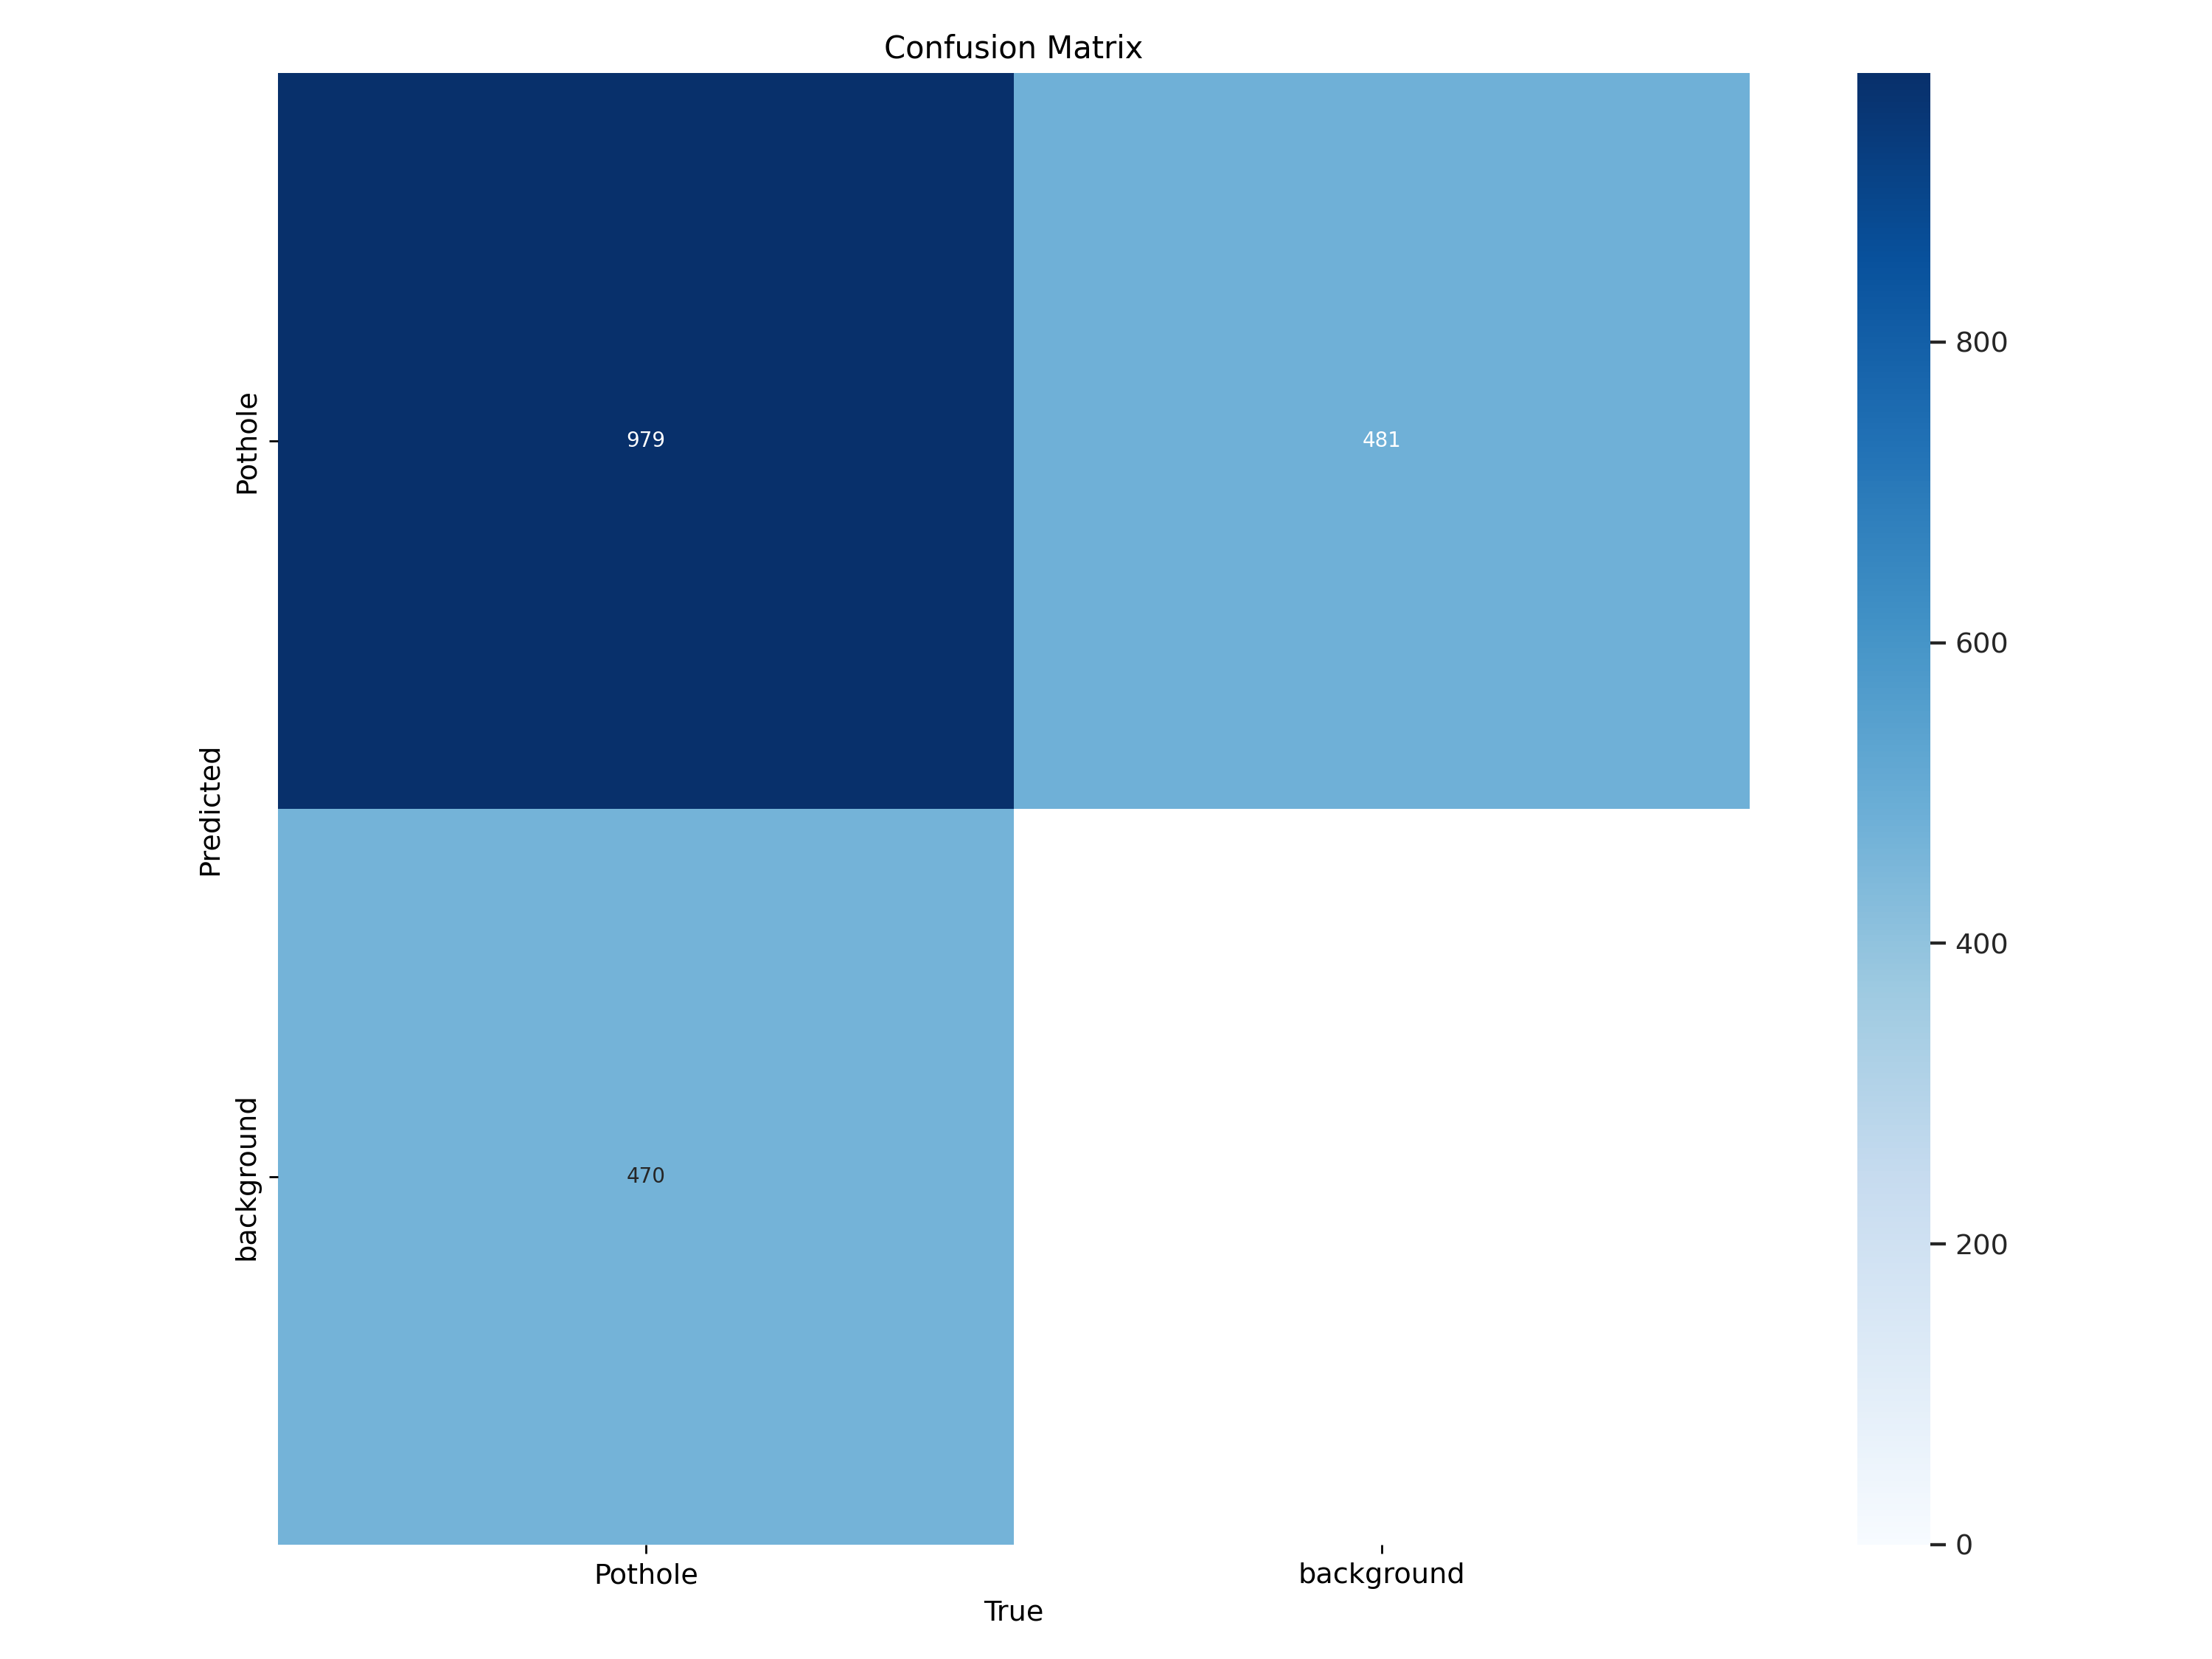

In [11]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

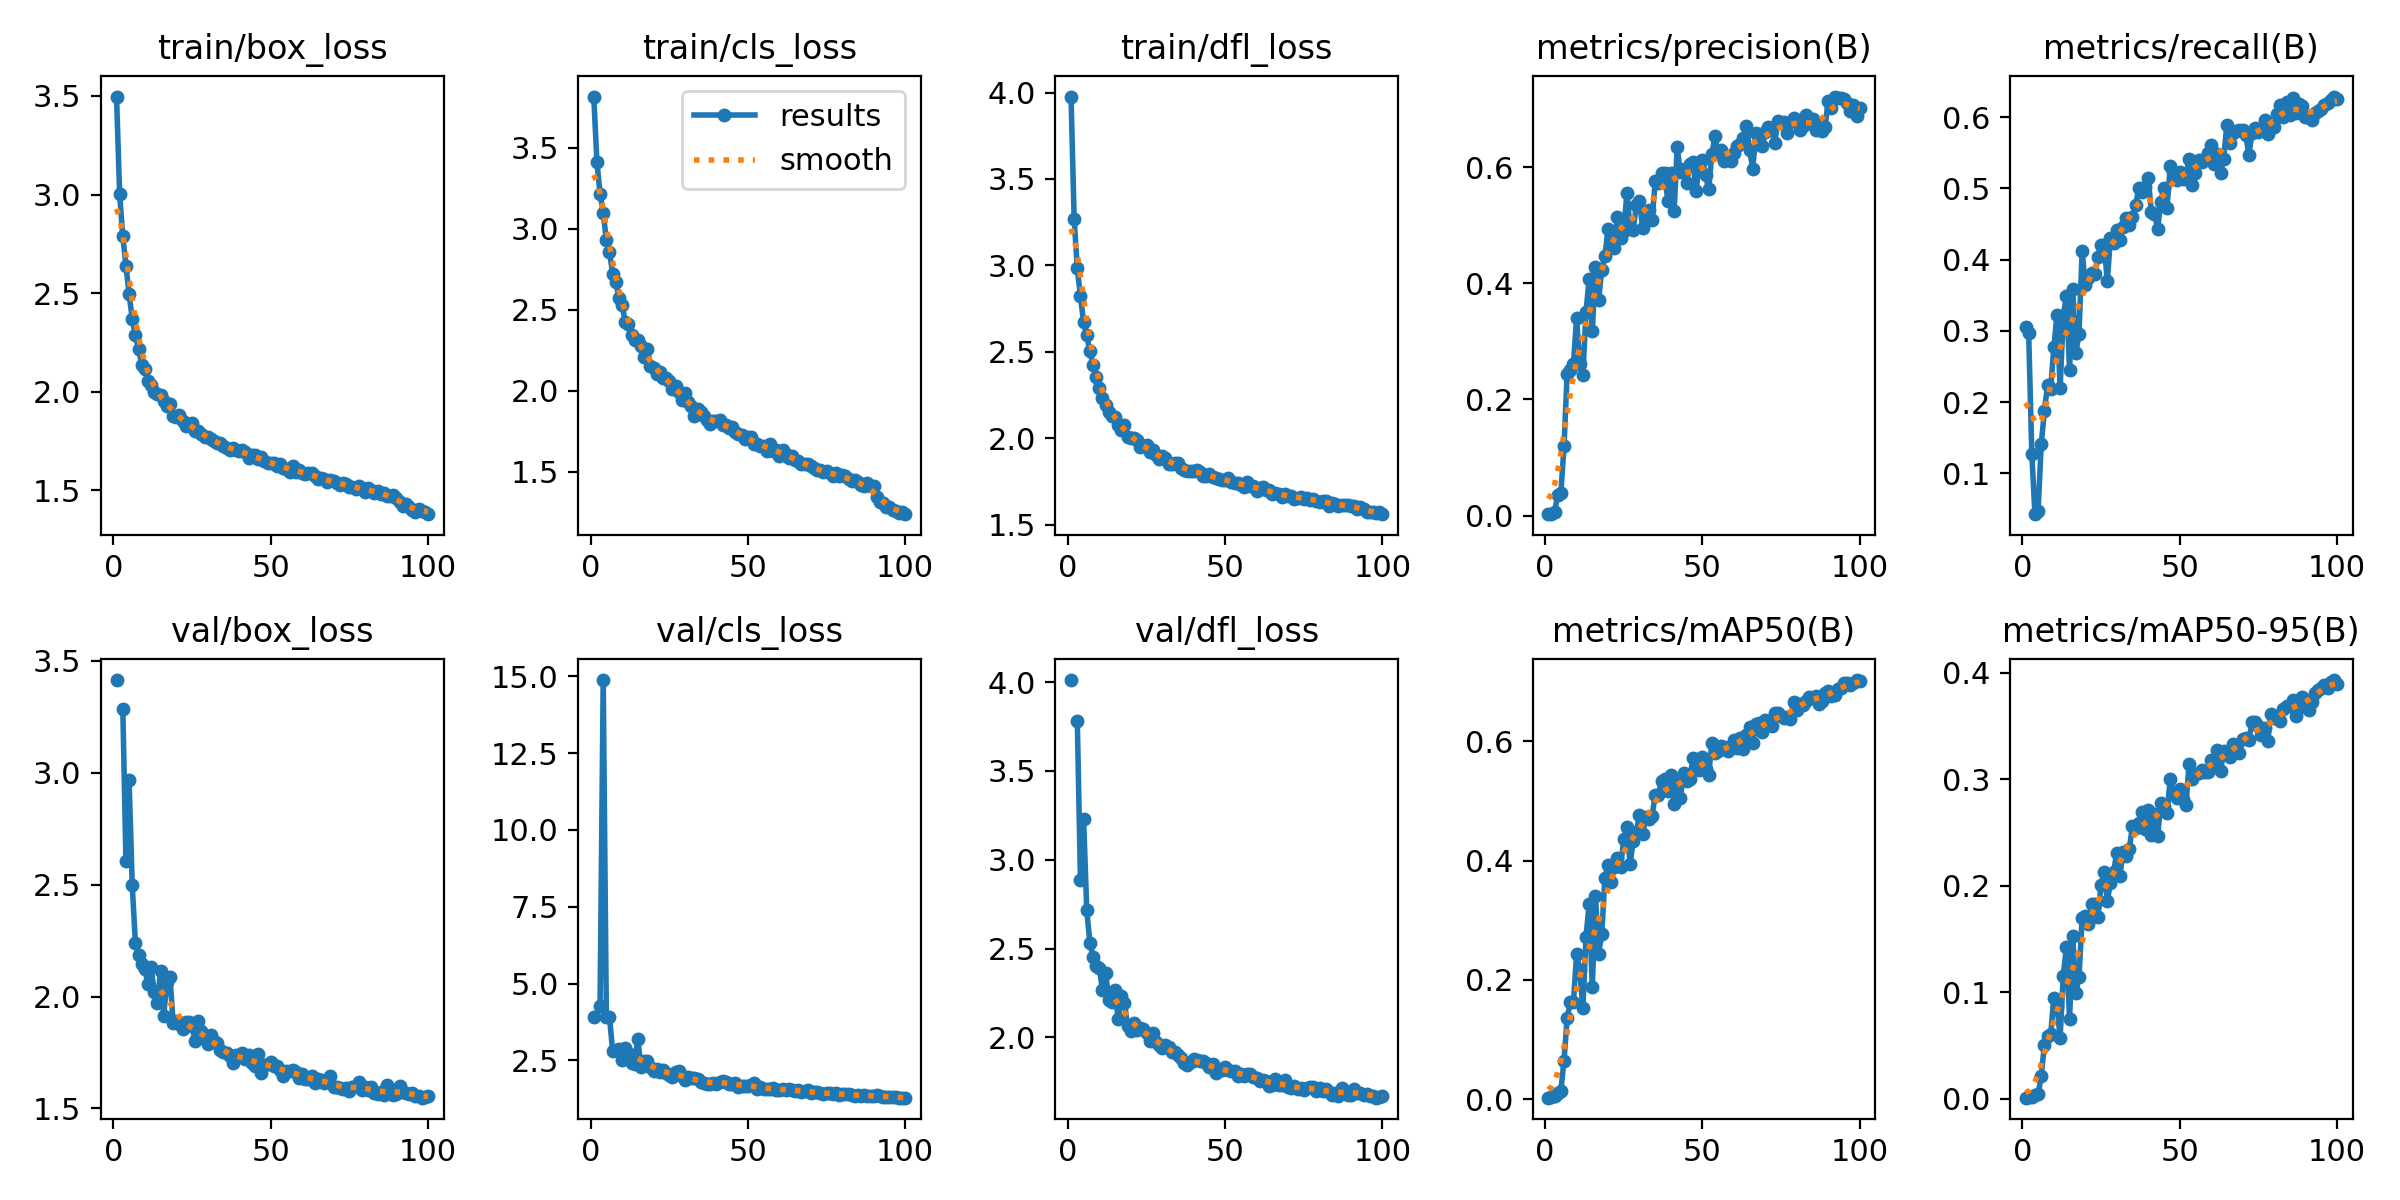

In [12]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [13]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Pothole']

In [14]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [15]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.3463216620006846
mAP 50 0.5957186346082562
mAP 75 0.3747559156196728


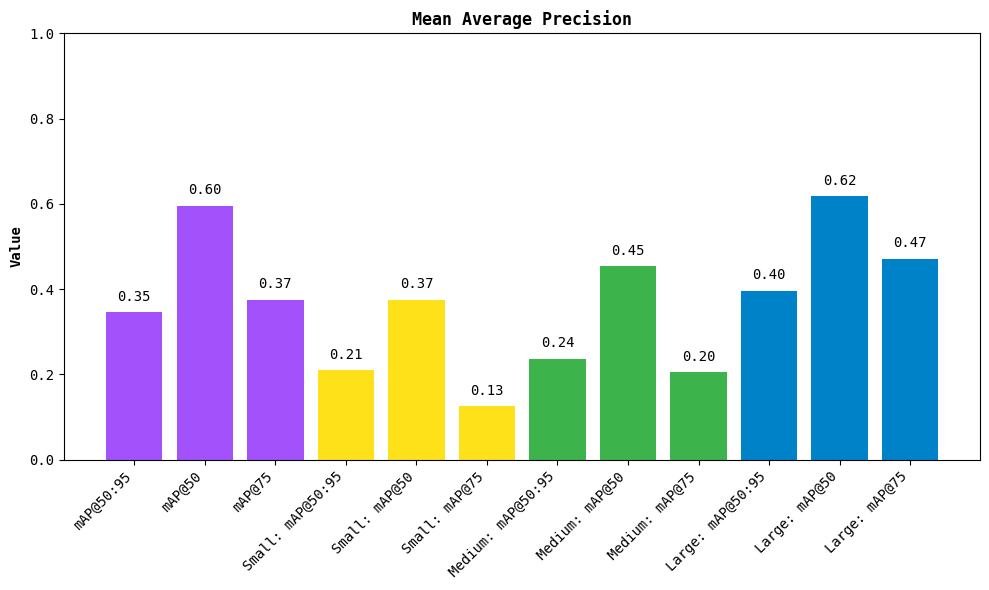

In [16]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [17]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

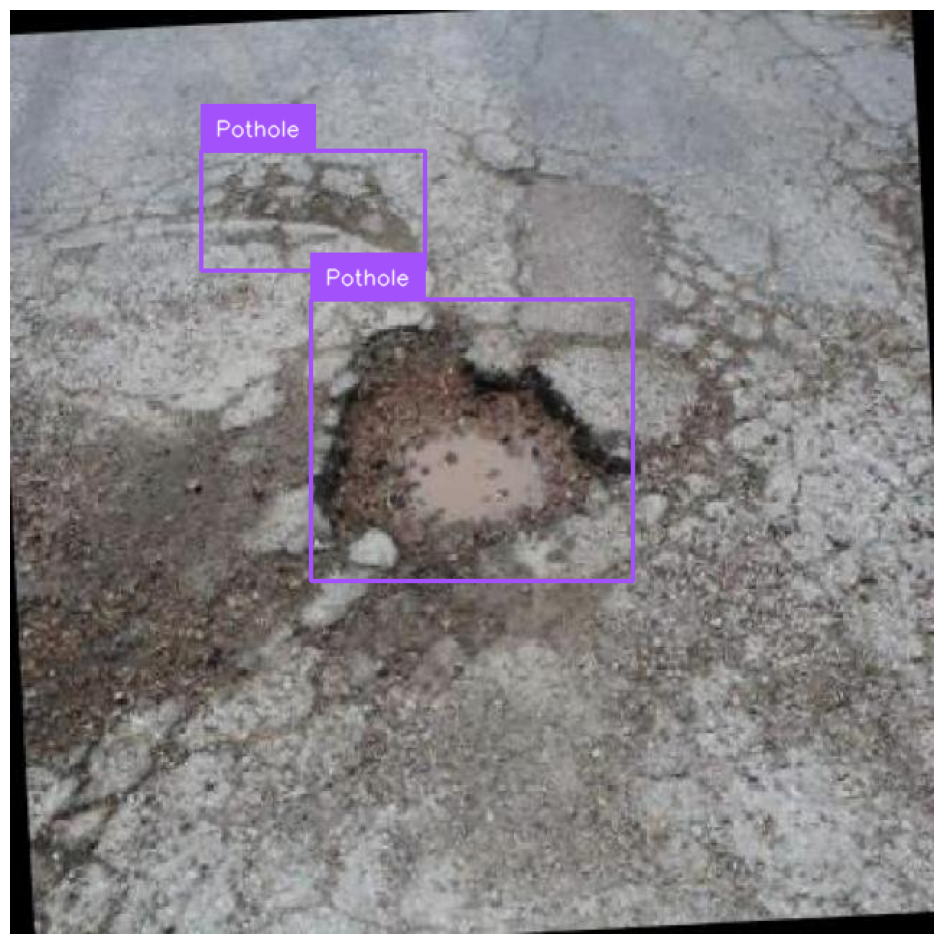

In [18]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [22]:
!pip show supervision  # Check version
!pip install -U supervision  # Upgrade if needed

Name: supervision
Version: 0.25.1
Summary: A set of easy-to-use utils that will come in handy in any Computer Vision project
Home-page: https://github.com/roboflow/supervision
Author: Piotr Skalski
Author-email: piotr.skalski92@gmail.com
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: contourpy, defusedxml, matplotlib, numpy, opencv-python, pillow, pyyaml, requests, scipy, tqdm
Required-by: 


In [24]:
help(sv.BoxAnnotator)


Help on class BoxAnnotator in module supervision.annotators.core:

class BoxAnnotator(supervision.annotators.base.BaseAnnotator)
 |  BoxAnnotator(color: Union[supervision.draw.color.Color, supervision.draw.color.ColorPalette] = ColorPalette(colors=[Color(r=163, g=81, b=251), Color(r=255, g=64, b=64), Color(r=255, g=161, b=160), Color(r=255, g=118, b=51), Color(r=255, g=182, b=51), Color(r=209, g=212, b=53), Color(r=76, g=251, b=18), Color(r=148, g=207, b=26), Color(r=64, g=222, b=138), Color(r=27, g=150, b=64), Color(r=0, g=214, b=193), Color(r=46, g=156, b=170), Color(r=0, g=196, b=255), Color(r=54, g=71, b=151), Color(r=102, g=117, b=255), Color(r=0, g=25, b=239), Color(r=134, g=58, b=255), Color(r=83, g=0, b=135), Color(r=205, g=58, b=255), Color(r=255, g=151, b=202), Color(r=255, g=57, b=201)]), thickness: int = 2, color_lookup: supervision.annotators.utils.ColorLookup = <ColorLookup.CLASS: 'class'>)
 |  
 |  A class for drawing bounding boxes on an image using provided detections.

In [26]:
import supervision as sv
from ultralytics import YOLO
from tqdm import tqdm
import cv2
from google.colab import files

# 1. Set up paths
SOURCE_VIDEO_PATH = "/content/potholevid.mp4"
TARGET_VIDEO_PATH = "/content/potholevid_annotated.mp4"
MODEL_PATH = "/content/yolov12n.pt"  # adjust if needed

# 2. Load video frames and info
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# 3. Initialize BoxAnnotator
box_annotator = sv.BoxAnnotator(
    thickness=2,
    color_lookup=sv.ColorLookup.CLASS
)

# 4. Load YOLOv8 model
model = YOLO(MODEL_PATH)

# 5. Annotate and write video
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames, desc="Processing video"):
        results = model(frame, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(results)

        # Filter only class 0 (Potholes)
        pothole_detections = detections[detections.class_id == 0]

        # Annotate bounding boxes
        annotated_frame = box_annotator.annotate(
            scene=frame.copy(),
            detections=pothole_detections
        )

        # (Optional) Add confidence labels manually
        for detection, confidence in zip(pothole_detections.xyxy, pothole_detections.confidence):
            x1, y1, _, _ = map(int, detection)
            label = f"Pothole {confidence:.2f}"
            cv2.putText(
                annotated_frame,
                label,
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 255, 255),
                1,
                cv2.LINE_AA
            )

        sink.write_frame(annotated_frame)

print(f"\n✅ Processing complete! Output saved to {TARGET_VIDEO_PATH}")

# 6. Download video (Colab only)
files.download(TARGET_VIDEO_PATH)


Processing video: 100%|██████████| 692/692 [00:23<00:00, 29.88it/s]


✅ Processing complete! Output saved to /content/potholevid_annotated.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
import supervision as sv
from ultralytics import YOLO
import cv2
from google.colab import files
from PIL import Image
import numpy as np

# 1. Set image and model path
IMAGE_PATH = "/content/OIP.jpg"
MODEL_PATH = "/content/yolov12n.pt"
OUTPUT_IMAGE_PATH = "/content/OIP_annotated.jpg"

# 2. Load image
image = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 3. Load model
model = YOLO(MODEL_PATH)

# 4. Run detection (lower conf threshold to be safe)
results = model(image_rgb, verbose=False, conf=0.1)[0]

# 5. Convert to Supervision detections
detections = sv.Detections.from_ultralytics(results)

# 6. Optional: check class IDs (for debugging)
print("Detected class IDs:", detections.class_id)

# 7. Filter only pothole class (assuming class 0 is pothole)
pothole_detections = detections[detections.class_id == 0]

# 8. Initialize box annotator
box_annotator = sv.BoxAnnotator(
    thickness=2,
    color_lookup=sv.ColorLookup.CLASS
)

# 9. Annotate
annotated_image = box_annotator.annotate(
    scene=image.copy(),
    detections=pothole_detections
)

# 10. Add confidence labels
for detection, confidence in zip(pothole_detections.xyxy, pothole_detections.confidence):
    x1, y1, _, _ = map(int, detection)
    label = f"Pothole {confidence:.2f}"
    cv2.putText(
        annotated_image,
        label,
        (x1, y1 - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255, 255, 255),
        1,
        cv2.LINE_AA
    )

# 11. Save and download annotated image
cv2.imwrite(OUTPUT_IMAGE_PATH, annotated_image)
files.download(OUTPUT_IMAGE_PATH)

print(f"✅ Detection complete. Annotated image saved at: {OUTPUT_IMAGE_PATH}")


Detected class IDs: [61 29]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Detection complete. Annotated image saved at: /content/OIP_annotated.jpg


In [28]:
model = YOLO("/content/yolov12n.pt")
print(model.names)


{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [30]:
model = YOLO("/content/runs/detect/train/weights/best.pt")
print(model.names)

{0: 'Pothole'}


In [1]:
import supervision as sv
from ultralytics import YOLO
import cv2
from google.colab import files
from PIL import Image
import numpy as np

# 1. Set image and model path
IMAGE_PATH = "/content/OIP.jpg"
MODEL_PATH = "/content/runs/detect/train/weights/best.pt"
OUTPUT_IMAGE_PATH = "/content/OIP_annotated.jpg"

# 2. Load image
image = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 3. Load model
model = YOLO(MODEL_PATH)

# 4. Run detection (lower conf threshold to be safe)
results = model(image_rgb, verbose=False, conf=0.1)[0]

# 5. Convert to Supervision detections
detections = sv.Detections.from_ultralytics(results)

# 6. Optional: check class IDs (for debugging)
print("Detected class IDs:", detections.class_id)

# 7. Filter only pothole class (assuming class 0 is pothole)
pothole_detections = detections[detections.class_id == 0]

# 8. Initialize box annotator
box_annotator = sv.BoxAnnotator(
    thickness=2,
    color_lookup=sv.ColorLookup.CLASS
)

# 9. Annotate
annotated_image = box_annotator.annotate(
    scene=image.copy(),
    detections=pothole_detections
)

# 10. Add confidence labels
for detection, confidence in zip(pothole_detections.xyxy, pothole_detections.confidence):
    x1, y1, _, _ = map(int, detection)
    label = f"Pothole {confidence:.2f}"
    cv2.putText(
        annotated_image,
        label,
        (x1, y1 - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255, 255, 255),
        1,
        cv2.LINE_AA
    )

# 11. Save and download annotated image
cv2.imwrite(OUTPUT_IMAGE_PATH, annotated_image)
files.download(OUTPUT_IMAGE_PATH)

print(f"✅ Detection complete. Annotated image saved at: {OUTPUT_IMAGE_PATH}")

ModuleNotFoundError: No module named 'supervision'

In [35]:
import supervision as sv
from ultralytics import YOLO
import cv2
from google.colab import files
import numpy as np

# 1. Set paths
IMAGE_PATH = "/content/OIP.jpg"
MODEL_PATH = "/content/runs/detect/train/weights/best.pt"
OUTPUT_IMAGE_PATH = "/content/OIP_annotated.jpg"

# 2. Load image
image = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 3. Load trained model
model = YOLO(MODEL_PATH)
print("Model classes:", model.names)

# 4. Run detection
results = model.predict(image_rgb, verbose=False, conf=0.1)[0]  # one image, so index 0

# 5. Convert to Supervision detections
detections = sv.Detections.from_ultralytics(results)

# 6. Check class IDs
print("Detected class IDs:", detections.class_id)

# 7. Filter for pothole class (id 0)
mask = detections.class_id == 0
pothole_detections = sv.Detections(
    xyxy=detections.xyxy[mask],
    confidence=detections.confidence[mask],
    class_id=detections.class_id[mask]
)

# 8. Annotate boxes
box_annotator = sv.BoxAnnotator(thickness=2, color_lookup=sv.ColorLookup.CLASS)
annotated_image = box_annotator.annotate(scene=image.copy(), detections=pothole_detections)

# 9. Add labels
for box, conf in zip(pothole_detections.xyxy, pothole_detections.confidence):
    x1, y1, x2, y2 = map(int, box)
    label = f"Pothole {conf:.2f}"
    cv2.putText(
        annotated_image,
        label,
        (x1, max(0, y1 - 10)),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255, 255, 255),
        1,
        cv2.LINE_AA
    )

# 10. Save and download
cv2.imwrite(OUTPUT_IMAGE_PATH, annotated_image)
files.download(OUTPUT_IMAGE_PATH)
print(f"✅ Detection complete. Annotated image saved at: {OUTPUT_IMAGE_PATH}")






Model classes: {0: 'Pothole'}
Detected class IDs: [0 0 0 0]


TypeError: 'MeanAveragePrecisionResult' object is not callable